# Lesson 08
Aluno: Luis Gustavo Ferreira Marques

Matricula: 180105604

Github:luisgfmarques

## Introdução
O trabalho a seguir tem como objetivo explorar o aprendizado de máquina aplicado à redes convolucionais e aplicar ao reconhecimento de imagens.

Para isso vamos identificar diferentes tipos de um carro,caminhão e bike.


##  Configurando o Ambiente

In [203]:
import numpy as np 
import pandas as pd
# !pip install -Uqq duckduckgo_search
# !pip install -Uqq fastai

from duckduckgo_search import ddg_images
from fastcore.all import *
from fastai.vision.all import *


def search_images(term, max_images=2000): return L(ddg_images(term, max_results=max_images)).itemgot('image')

## Baixando e Analisando as Imagens


/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


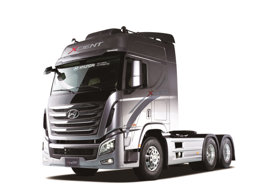

In [204]:
from fastai.vision.all import *
from fastdownload import download_url

download_url(search_images('heavy_truck', max_images=1)[0], 'truck.jpg', show_progress=False)
Image.open('truck.jpg').to_thumb(256,256)

Vamos baixar as imagens e organizar os dados usando um bloco de dados (DataBlock). Isso inclui especificar o que são as entradas (imagens) e as saídas (categorias), além de aplicar transformações nos dados e dividir tudo em conjuntos de treinamento e validação.

In [205]:
searches = 'heavy_truck','car','bike'
path = Path('vehicle')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o}'))
    sleep(1)  
    resize_images(path/o, max_size=400, dest=path/o)

In [206]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

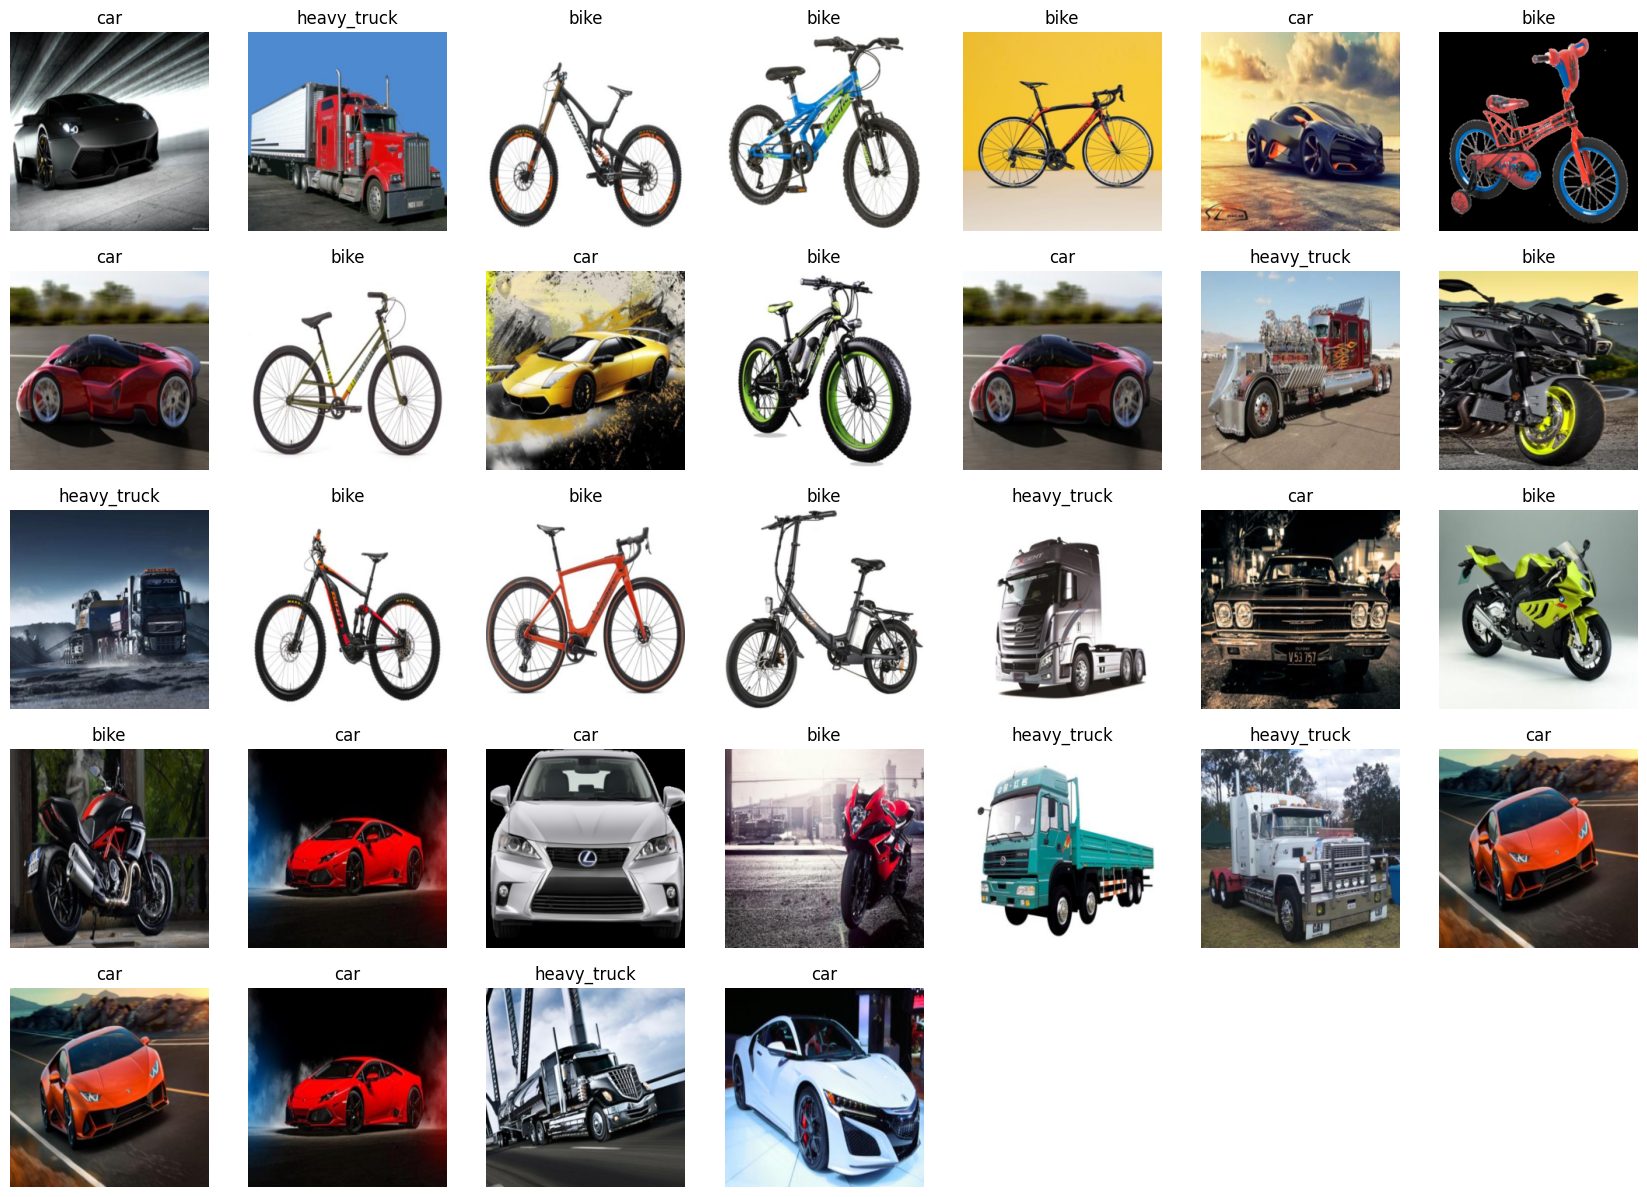

In [207]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=32)


# Convolução

A convolução é basicamente uma maneira matemática de combinar duas funções para criar uma terceira. Quando aplicada a imagens, isso significa sobrepor um filtro à imagem, multiplicando os valores ponto a ponto. Ao deslocar o filtro pela imagem, obtemos uma nova imagem transformada. A escolha e configuração do filtro podem causar efeitos como desfoque, ajuste de cores, detecção de bordas, entre outros. No exemplo abaixo, vamos criar um filtro para reduzir a saturação geral da imagem e destacar a cor vermelha.

A célula abaixo define um filtro 3x3x3 (3 dimensões para as cores RGB) com valores específicos para dessaturar a imagem, mantendo uma ênfase na cor verde. Esse filtro será aplicado à imagem na célula 4.

## Dropout

O dropout é uma técnica comum de regularização em redes neurais, especialmente em redes convolucionais, para evitar o overfitting. O overfitting acontece quando a rede aprende padrões específicos dos dados de treinamento que não são aplicáveis a novos dados. O dropout resolve isso ao desativar aleatoriamente alguns neurônios durante o treinamento, impedindo que a rede dependa demasiadamente de neurônios específicos e, assim, melhorando a capacidade de generalização.

A função show_img na célula Abaixo é uma função que exibe uma imagem. Ela usa a biblioteca Matplotlib para mostrar uma imagem, definindo um título e desativando os eixos para melhor visualização.

In [213]:
def show_img(img, title="Image"):
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

A célula abaixo contém a função dropout_np, que implementa a técnica de dropout de forma manual usando a biblioteca NumPy. A função recebe uma imagem e um fator de dropout como entrada. Ela gera um tensor aleatório do mesmo formato que a imagem e cria uma máscara binária onde os valores são 1 se forem maiores que o fator de dropout e 0 caso contrário. A imagem original é então multiplicada por essa máscara, resultando em uma nova imagem onde parte dos pixels foi "desativada".

In [214]:
def dropout_np(img, factor=0.5):
    random_tensor = np.random.rand(*img.shape)
    dropout_mask = (random_tensor > factor).astype(np.uint8)
    return img * dropout_mask

# Criação dos modelos

Para realizar o teste, foi utilizado 5 abordagens de aprendizado utilizando visão computacional, e no final gerado um grafico comparativo com os erros.

## Modelo resnet50

Utiliza a arquitetura ResNet50 para transfer learning em um problema de visão computacional.


In [215]:
learn = vision_learner(dls, resnet50)
learn.fine_tune(10)


epoch,train_loss,valid_loss,time
0,0.692712,0.023817,00:05


epoch,train_loss,valid_loss,time
0,0.025444,0.001564,00:06
1,0.020216,0.002509,00:06
2,0.019761,0.021836,00:06
3,0.024100,0.011912,00:06
4,0.019359,0.004710,00:06
5,0.023888,0.002048,00:06
6,0.019174,0.000082,00:06
7,0.016264,0.000033,00:06
8,0.013856,0.000029,00:06
9,0.012276,0.000026,00:06


## Modelo Manual

Implementa uma rede convolucional simples (Simple CNN) utilizando camadas convolucionais e uma camada completamente conectada.
Esta rede é treinada do zero.

In [216]:
def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res


In [217]:
simple_cnn = sequential(
    conv(3 ,4),
    conv(4 ,8),
    conv(8 ,16),
    conv(16,32),
    conv(32,2, act=False),
    Flatten(),
    nn.Dropout(0.2),
)

In [218]:
learn2 = Learner(dls, simple_cnn)
learn2.fine_tune(10)

epoch,train_loss,valid_loss,time
0,4.783852,4.570251,00:02


epoch,train_loss,valid_loss,time
0,4.506587,4.357459,00:02
1,4.282976,3.387197,00:02
2,3.726079,1.996678,00:02
3,3.351908,1.899536,00:02
4,3.131159,1.859197,00:01
5,3.003708,1.842595,00:02
6,2.888334,1.851687,00:02
7,2.797811,1.835889,00:01
8,2.711063,1.833805,00:02
9,2.648163,1.833691,00:02


## Modelo ResNet34
Utiliza a arquitetura ResNet34 para transfer learning em um problema de visão computacional.

In [219]:
learn3 = vision_learner(dls, resnet34)
learn3.fine_tune(10)

epoch,train_loss,valid_loss,time
0,0.948787,0.018530,00:03


epoch,train_loss,valid_loss,time
0,0.062016,0.008776,00:03
1,0.047261,0.019904,00:03
2,0.029562,0.002403,00:03
3,0.021109,0.005469,00:03
4,0.022658,0.057478,00:03
5,0.024541,0.040577,00:03
6,0.019019,0.039605,00:03
7,0.014395,0.046382,00:03
8,0.011170,0.051313,00:03
9,0.009372,0.052611,00:03


# Rede Neural Personalizada com Normalização em Lote (Batch Normalization)

Esta implementação refere-se a uma arquitetura de rede neural convolucional (CNN) adaptada de maneira personalizada, incorporando camadas de Normalização em Lote (Batch Normalization - BN). A inclusão da BN tem como objetivo aprimorar a estabilidade durante o treinamento, contribuindo para uma convergência mais eficaz do modelo e, consequentemente, melhorando seu desempenho.

In [220]:

custom_cnn_with_bn = sequential(
    conv(3, 4),
    conv(4, 8),
    conv(8, 16),
    conv(16, 32),
    conv(32, 2, act=False),
    BatchNorm(2),
    nn.ReLU(),
    Flatten(),
    nn.Dropout(0.2),
)

# Learner para Custom CNN with BN
learn4 = Learner(dls, custom_cnn_with_bn)
learn4.fit_one_cycle(10)


epoch,train_loss,valid_loss,time
0,3.344228,4.833390,00:02
1,3.207484,4.748430,00:02
2,3.076296,4.550430,00:02
3,3.016415,4.224522,00:02
4,2.962237,3.641656,00:02
5,2.964028,2.997129,00:02
6,2.945097,2.654217,00:02
7,2.935966,2.531887,00:02
8,2.903350,2.460130,00:01
9,2.887435,2.448695,00:02


# Modelo ResNet18

Aplica a arquitetura ResNet18 para transfer learning em um desafio de visão computacional. Este processo envolve a utilização de conhecimentos prévios obtidos durante o treinamento em conjuntos de dados massivos, aprimorando assim a capacidade do modelo em abordar especificamente a tarefa em questão relacionada à visão computacional.

In [221]:
learn5 = vision_learner(dls, resnet18)
learn5.fine_tune(10)

epoch,train_loss,valid_loss,time
0,0.870819,0.012680,00:02


epoch,train_loss,valid_loss,time
0,0.107583,0.023044,00:02
1,0.063673,0.009488,00:02
2,0.051227,0.002127,00:02
3,0.034641,0.003127,00:02
4,0.025905,0.001228,00:02
5,0.021654,0.001091,00:02
6,0.016051,0.001152,00:02
7,0.012054,0.000798,00:02
8,0.009346,0.000628,00:02
9,0.007264,0.000643,00:03


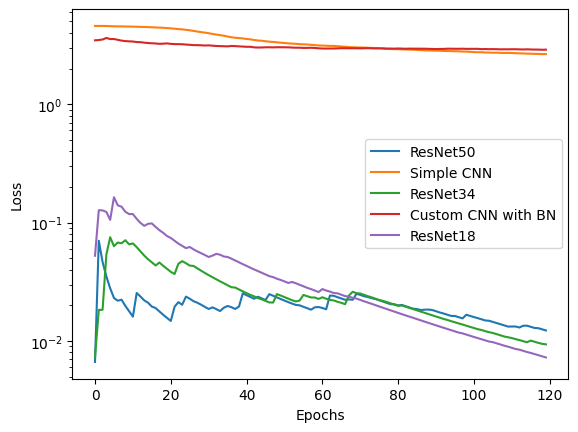

In [222]:
recorders = [learn.recorder, learn2.recorder, learn3.recorder, learn4.recorder, learn5.recorder]
names = ["ResNet50", "Simple CNN", "ResNet34", "Custom CNN with BN", "ResNet18"]

for rec, name in zip(recorders, names):
    plt.plot(rec.losses, label=name)

plt.yscale('log')  # Set the y-axis to log scale
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


In [227]:
training_results = {}

# Extracting relevant information from recorders
for rec, name in zip(recorders, names):
    training_results[name] = {
        'Epochs': len(rec.losses),
        'Final Loss': rec.losses[-1],
    }

training_results

{'ResNet50': {'Epochs': 120, 'Final Loss': TensorBase(0.0123)},
 'Simple CNN': {'Epochs': 120, 'Final Loss': TensorBase(2.6482)},
 'ResNet34': {'Epochs': 120, 'Final Loss': TensorBase(0.0094)},
 'Custom CNN with BN': {'Epochs': 120, 'Final Loss': TensorBase(2.8874)},
 'ResNet18': {'Epochs': 120, 'Final Loss': TensorBase(0.0073)}}

Deep learning

## Conclusão e Hugging face


Pode-se observar que a ResNet18 para este problema foi o melhor modelo, com isso foi decidido a sua utilização para a apresentação final do projeto

A aplicação no hugging face está disponivel [Aqui](https://huggingface.co/spaces/fastaioncampus/vehicle_diferrence)

In [228]:
learn5.export('model.pkl')